In [21]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *
import pyreadr
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [63]:
ABCD = pd.read_csv('../dataset/abcd.csv')

/var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_85221/2452555509.py:1: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ABCD = pd.read_csv('../dataset/abcd.csv')


In [68]:
ABCD.abcl_scr_sub_use_alcohol_t

0         NaN
1        50.0
2        50.0
3         NaN
4         NaN
         ... 
22285    64.0
22286     NaN
22287     NaN
22288     NaN
22289    50.0
Name: abcl_scr_sub_use_alcohol_t, Length: 22290, dtype: float64

# Read in the data

In [86]:
ABCD = pd.read_csv('../dataset/abcd.csv')
list_ROI = pyreadr.read_r('../dataset/ABCD_ROI.list.RData')

/var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_85221/2387974615.py:1: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ABCD = pd.read_csv('../dataset/abcd.csv')


In [152]:
ABCD_sub = ABCD
#'cbcl_scr_syn_internal_t', 'cbcl_scr_syn_anxdep_t', 'abcl_scr_sub_use_alcohol_t',
outcome_var = 'cbcl_scr_syn_internal_t'
# 'rsmri_list', 'tfmri_list', 'smri_list', 'dti_list', 'rsi_list'
modality_var ='tfmri_list'
cov = list(np.squeeze(list_ROI[modality_var].values,1))
cov.extend([outcome_var,'eventname',
            "mri_info_manufacturers.model.name", 'race.6level', 'age', 'female', 'subjectid', 'demo_rel_family_id.bl'])
# getting the relevent columns
ABCD_sub = ABCD_sub.loc[:,np.isin(ABCD_sub.columns,cov)]
# getting the subjects without na
ABCD_sub = ABCD_sub.loc[~ABCD_sub.isnull().any(axis = 1),:]
# sample one subject in the families
ABCD_sub = ABCD_sub.groupby('demo_rel_family_id.bl', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
# sample one subject in the visit
ABCD_sub = ABCD_sub.groupby(['subjectid','eventname'], group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
# drop the subjectid and family id
ABCD_sub.drop(columns = ['subjectid', 'demo_rel_family_id.bl','eventname'], inplace=True)
# Onehotencode the categorical variables
cate_cov = ['race.6level', 'female',"mri_info_manufacturers.model.name"]
OHE = OneHotEncoder(drop = 'first',sparse_output = False).fit(ABCD_sub[cate_cov])
encoded_cols = list(OHE.get_feature_names_out(cate_cov))
ABCD_sub[encoded_cols] = OHE.transform(ABCD_sub[cate_cov])


In [153]:
X = ABCD_sub[encoded_cols+list(np.squeeze(list_ROI[modality_var].values,1))].to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
z = ABCD_sub[outcome_var].to_numpy() 
z = z- min(z)

In [154]:
print(X.shape)

(8893, 895)


(array([1538., 1758., 2320., 1228., 1046.,  668.,  255.,   68.,    9.,
           3.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <BarContainer object of 10 artists>)

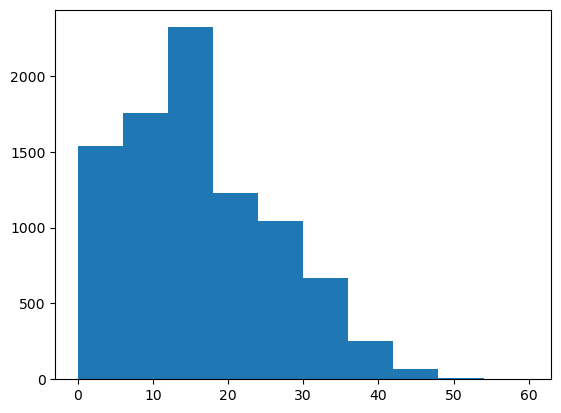

In [155]:
plt.hist(z)

At iteration 0, the loss is 42360.159970521796


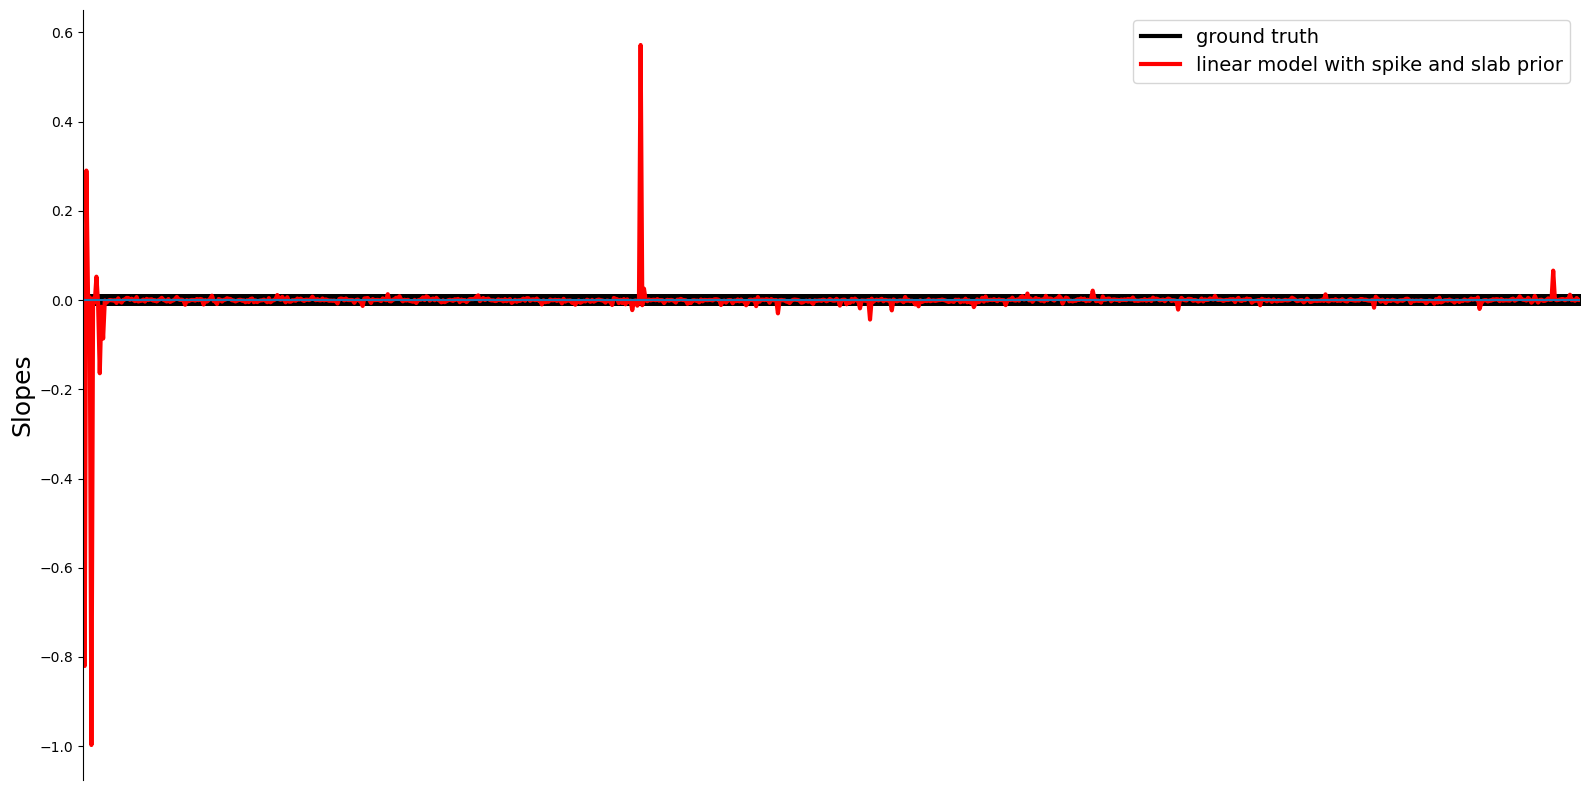

In [156]:
# Model parameters
batch_size = X.shape[0]
exact_lh = True
tobit = True
device = 'cpu'
X = torch.tensor(X)
z = torch.tensor(z)
n = X.shape[0]
p = X.shape[1]
sim_data = Sim_Dataset(X, z, device = device)
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
true_beta = np.zeros((p,))
model = linear_slab_spike(p = p, n_total = n, init_pi_local_max = 1.0, init_pi_local_min = 0.0,init_pi_global = 0.5, init_beta_var =1, init_noise_var = 1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=0.1, init_a3= 1.1, init_a4 = 1.1,
                          b1 = 1.1, b2 = 1.1, init_b3 = 10.0, init_b4 = 0.1, n_E = 1
                          , prior_sparsity = True, prior_sparsity_beta = False,exact_lh = exact_lh,tobit = tobit, device = device
                         ).double().to(device)
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local},
     {'params': model.log_a3},
     {'params': model.log_a4},
     {'params': model.b3},
     {'params': model.log_b4},
     {'params': model.bias},
     {'params': model.logit_pi_global},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
    ],
    lr = 0.05)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
t = 100 #number of moving averages
patience = 100# patience
_, result_dict = train_and_infer(model = model, optimizer = optimizer, sim_data_loader = sim_data_loader, lr_scheduler = lr_scheduler, t = t, patience = patience,X = X, plot = True, true_beta = true_beta, verbose = True)

In [157]:
result_dict

{'mean_h_est': [0.023744109047736908],
 'h_est_upper': [0.03200954870727073],
 'h_est_lower': [0.016880653496584023],
 'mean_var_genetic': [3.119770195312777],
 'noise_var': [128.23814128396322],
 'global_pi': [0.051757136537791425],
 'global_pi_upper': [0.11531191591774514],
 'global_pi_lower': [0.0128112512872296]}